## Importando dados de fragmentação (MS/MS)

A biblioteca _matchms_ pode importar dados de MS/MS em vários formatos, como .mzml, .mzxml ou arquivos .mgf no estilo GNPS. Outra opção seria usar o Identificador Universal de Espectro para espectros de massa [_Universal Spectrum Identifier for mass spectra_](https://www.biorxiv.org/content/10.1101/2020.12.07.415539v1.full).
Vamos começar com alguns espectros do GNPS em formato de arquivo .mgf que podem ser obtidos [aqui](https://external.gnps2.org/gnpslibrary). Para o exemplo a seguir, baixamos esta biblioteca de espectros.

In [ ]:
!pip install matchms

In [1]:
!wget https://external.gnps2.org/gnpslibrary/GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf

--2025-09-30 10:21:40--  https://external.gnps2.org/gnpslibrary/GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
Resolving external.gnps2.org (external.gnps2.org)... 169.235.26.136
Connecting to external.gnps2.org (external.gnps2.org)|169.235.26.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39095019 (37M) [application/octet-stream]
Saving to: ‘GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf’

GNPS-NIH-NATURALPRO 100%[===================>]  37,28M  6,22MB/s    in 12s     

2025-09-30 10:21:53 (3,18 MB/s) - ‘GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf’ saved [39095019/39095019]



In [2]:
import os
from matchms.importing import load_from_mgf

spectra = list(load_from_mgf("GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf"))

Cada um desses objetos contém os metadados do espectro `spectrum.metadata` e os picos do espectro `spectrum.peaks` com `spectrum.peaks.mz` e `spectrum.peaks.intensities`.

In [3]:
spectra[4].metadata

{'charge': 1,
 'ionmode': 'positive',
 'smiles': 'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'usi': 'mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY:accession:CCMSLIB00000079354',
 'scans': '2030',
 'ms_level': '2',
 'instrument_type': 'LC-ESI-qTof',
 'file_name': 'p1-A05_GA5_01_17878.mzXML',
 'peptide_sequence': '*..*',
 'organism_name': 'GNPS-NIH-NATURALPRODUCTSLIBRARY',
 'compound_name': '"MLS001158449-01!(2S)-2-[[(2S)-3-methyl-2-[[(2S)-3-oxo-2-propan-2-yl-2,4-dihydroquinoxaline-1-carbonyl]amino]butanoyl]amino]-3-phenylpropanoic acid" M+H',
 'principal_investigator': 'Dorrestein',
 'data_collector': 'VVP/LMS',
 'submit_user': 'vphelan',
 'confidence': '1',
 'spectrum_id': 'CCMSLIB00000079354',
 'precursor_mz': 481.245}

In [4]:
spectra[4].get("smiles")

'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O'

Podemos inspecionar mais de perto em algumas entradas de metadados importantes, como smiles, InChIKey e InChIs.

In [5]:
import numpy as np

inchikeys = [s.get("inchikey") for s in spectra]
found_inchikeys = np.sum([1 for x in inchikeys if x is not None])
print(f"Found {int(found_inchikeys)} inchikeys in metadata")

Found 0 inchikeys in metadata


Text(0, 0.5, 'Number of spectra')

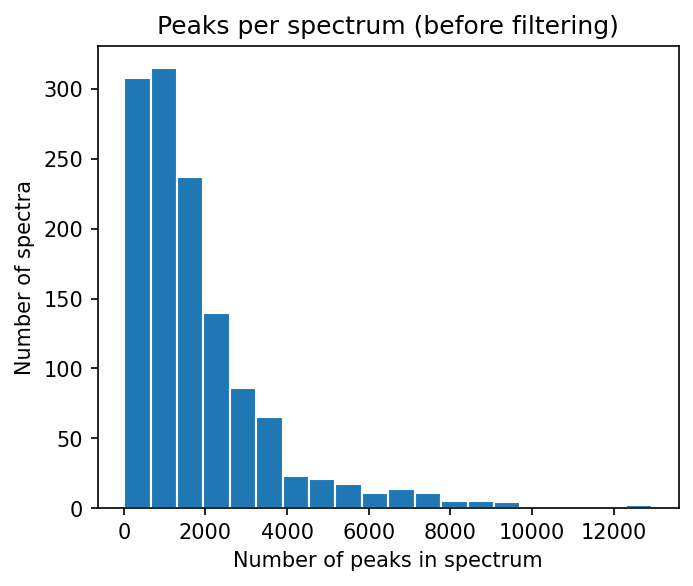

In [6]:
from matplotlib import pyplot as plt

numbers_of_peaks = [len(s.peaks.mz) for s in spectra]

plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

## Criar um _pipeline_ de processamento de dados

Dependendo dos dados importados,  pode-se querer processar os espectros posteriormente. O _matchms_ oferece diversos "filtros" para processar objetos do Spectrum. Eles são projetados de forma a permitir que sejam facilmente empilhados em qualquer pipeline de processamento desejado. Em geral, o `matchms.filtering` contém filtros que irão

- harmonizar, limpar, estender e/ou verificar os metadados do espectro
- processar ou filtrar picos do espectro (por exemplo, remover picos de baixa intensidade ou normalizar as intensidades dos picos)

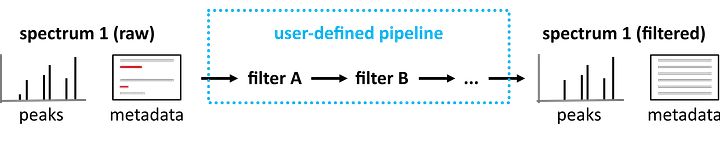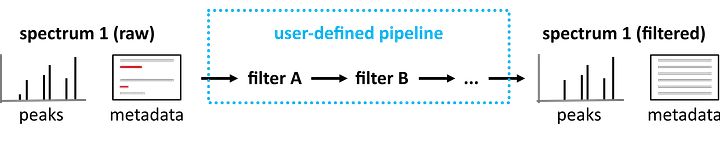

Um pipeline de pré-processamento típico pode consistir em duas partes, uma para limpar os metadados e outra para processar ainda mais os picos.

In [7]:
import matchms.filtering as ms_filters

def metadata_processing(spectrum):
    spectrum = ms_filters.default_filters(spectrum)
    spectrum = ms_filters.repair_inchi_inchikey_smiles(spectrum)
    spectrum = ms_filters.derive_inchi_from_smiles(spectrum)
    spectrum = ms_filters.derive_smiles_from_inchi(spectrum)
    spectrum = ms_filters.derive_inchikey_from_inchi(spectrum)
    spectrum = ms_filters.harmonize_undefined_smiles(spectrum)
    spectrum = ms_filters.harmonize_undefined_inchi(spectrum)
    spectrum = ms_filters.harmonize_undefined_inchikey(spectrum)
    spectrum = ms_filters.add_precursor_mz(spectrum)
    return spectrum

def peak_processing(spectrum):
    spectrum = ms_filters.default_filters(spectrum)
    spectrum = ms_filters.normalize_intensities(spectrum)
    spectrum = ms_filters.select_by_intensity(spectrum, intensity_from=0.01)
    spectrum = ms_filters.select_by_mz(spectrum, mz_from=10, mz_to=1000)
    return spectrum

In [8]:
spectra = [metadata_processing(s) for s in spectra]
spectra = [peak_processing(s) for s in spectra]

In [9]:
inchikeys = [s.get("inchikey") for s in spectra]
inchikeys[:10]

['XTJNPXYDTGJZSA-PKOBYXMFSA-N',
 'VOYWJNWCKFCMPN-FHERZECASA-N',
 'IRZVHDLBAYNPCT-UHFFFAOYSA-N',
 'OPWCHZIQXUKNMP-RGEXLXHISA-N',
 'GTBYYVAKXYVRHX-BVSLBCMMSA-N',
 'UVZWLAGDMMCHPD-UHFFFAOYSA-N',
 'XKWILXCQJFNUJH-DEOSSOPVSA-N',
 'JDZNIWUNOASRIK-UHFFFAOYSA-N',
 'RCAVVTTVAJETSK-VXKWHMMOSA-N',
 'KQAZJQXFNDOORW-CABCVRRESA-N']

Existem várias opções para exportar seus dados após o processamento. Usando `save_as_json` ou `save_as_mgf`, os dados podem ser gravados novamente em um arquivo .json ou .mgf.

In [10]:
from matchms.exporting import save_as_json

save_as_json(spectra, "GNPS-NIH- NATURALPRODUCTSLIBRARY_processed.json")

dict_keys(['spectra'])


## Calcular similaridades de espectros: _Score_ de cosseno

Calcular similaridades de espectros é uma das principais funcionalidades do _matchms_. O fluxo de trabalho geral é exibido na Figura

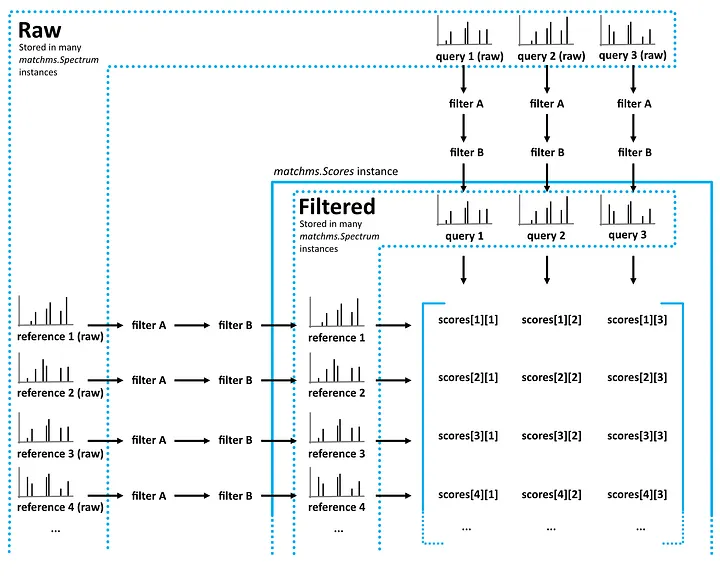

In [11]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

similarity_measure = CosineGreedy(tolerance=0.005)

scores = calculate_scores(spectra, spectra, similarity_measure, is_symmetric=True)

In [12]:
scores.n_cols

1267

In [13]:
scores.scores

<1267x1267x2 stacked sparse array containing scores for ('CosineGreedy_score', 'CosineGreedy_matches') with 964913 stored elements in COOrdinate format>

In [22]:
scores.scores['CosineGreedy_score']

(array([   0,    0,    0, ..., 1266, 1266, 1266]),
 array([   0,    1,    2, ..., 1264, 1265, 1266]),
 array([1.00000000e+00, 6.41050958e-03, 1.70386100e-04, ...,
        1.65838832e-02, 4.29585481e-02, 1.00000000e+00]))

In [20]:
help(scores.scores_by_query)

Help on method scores_by_query in module matchms.Scores:

scores_by_query(query: 'QueriesType', name: 'str' = None, sort: 'bool' = False) -> 'np.ndarray' method of matchms.Scores.Scores instance
    Return all scores for the given query spectrum.
    
    For example
    
    .. testcode::
    
        import numpy as np
        from matchms import calculate_scores, Scores, Spectrum
        from matchms.similarity import CosineGreedy
    
        spectrum_1 = Spectrum(mz=np.array([100, 150, 200.]),
                              intensities=np.array([0.7, 0.2, 0.1]),
                              metadata={'id': 'spectrum1'})
        spectrum_2 = Spectrum(mz=np.array([100, 140, 190.]),
                              intensities=np.array([0.4, 0.2, 0.1]),
                              metadata={'id': 'spectrum2'})
        spectrum_3 = Spectrum(mz=np.array([110, 140, 195.]),
                              intensities=np.array([0.6, 0.2, 0.1]),
                              metadata={'id': '

In [21]:
best_matches = scores.scores_by_query(spectra[5], 'CosineGreedy_score', sort=True)[:10]

print([x[1] for x in best_matches])

[(1., 30), (0.99711049, 2), (0.99534901, 2), (0.99214557, 2), (0.98748381, 2), (0.98461111, 3), (0.98401833, 2), (0.97598497, 2), (0.9757458, 2), (0.97547771, 2)]


In [23]:
[x[0].get("smiles") for x in best_matches]

['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1cc(=O)oc2cc(OC(=O)c3ccccc3)ccc12',
 'O=C(Nc1ccccc1OC(=O)c2ccccc2)c3ccccc3',
 'COc1cc(CC=C)ccc1OC(=O)c2ccccc2',
 'O=C(OCC1OC(C(OC(=O)c2ccccc2)C1OC(=O)c3ccccc3)n4ncc(=O)[nH]c4=O)c5ccccc5',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COC(=O)CNC(=O)c1ccccc1',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1C=C4C(=O)NC(=O)NC4=O',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(C)C4=O']

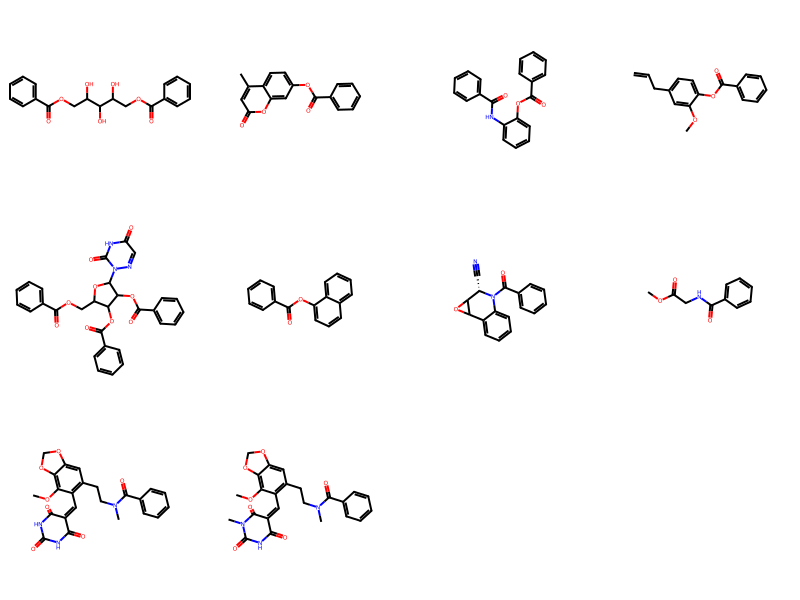

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = []
for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    mols.append(m)

Draw.MolsToGridImage(mols,molsPerRow=4)

Alternativamente pode se obter as melhores correspondências (_matches_) acima do limite ‘min_match’.

In [32]:
min_match = 5
sorted_matches = scores.scores_by_query(spectra[5], 'CosineGreedy_score', sort=True)
best_matches = [x for x in sorted_matches if x[1][1] >= min_match][:10]

[x[1] for x in best_matches]

[(1., 30),
 (0.44857215, 6),
 (0.39605775, 5),
 (0.33880658, 5),
 (0.03942863, 6),
 (0.03429136, 5),
 (0.03028157, 5),
 (0.02845932, 5),
 (0.01924283, 7),
 (0.01890612, 5)]

Calcular similaridades de espectros: _Score_ de cosseno modificado [Watrous et al. (PNAS, 2012)](https://www.pnas.org/content/109/26/E1743).

In [33]:
%%timeit

from matchms.similarity import ModifiedCosine

similarity_measure = ModifiedCosine(tolerance=0.005)
scores = calculate_scores(spectra, spectra, similarity_measure,
                          is_symmetric=True)

1min 33s ± 4.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
scores_array = scores.scores.to_array()
scores_array

array([[(1.00000000e+00,  40), (6.41050958e-03,   2),
        (1.70386100e-04,   1), ..., (1.40989588e-02,   2),
        (2.31023370e-02,   8), (4.92107818e-03,   7)],
       [(6.41050958e-03,   2), (1.00000000e+00,  75),
        (1.37105333e-02,   2), ..., (0.00000000e+00,   0),
        (1.17750837e-02,  14), (1.31190775e-03,   5)],
       [(1.70386100e-04,   1), (1.37105333e-02,   2),
        (1.00000000e+00,  37), ..., (0.00000000e+00,   0),
        (1.03986106e-02,   7), (3.35509125e-03,   9)],
       ...,
       [(1.40989588e-02,   2), (0.00000000e+00,   0),
        (0.00000000e+00,   0), ..., (1.00000000e+00,  38),
        (1.24833209e-02,   9), (1.65838832e-02,  15)],
       [(2.31023370e-02,   8), (1.17750837e-02,  14),
        (1.03986106e-02,   7), ..., (1.24833209e-02,   9),
        (1.00000000e+00, 500), (4.29585481e-02,  65)],
       [(4.92107818e-03,   7), (1.31190775e-03,   5),
        (3.35509125e-03,   9), ..., (1.65838832e-02,  15),
        (4.29585481e-02,  65), (1.0

Text(0, 0.5, 'Spectrum #ID')

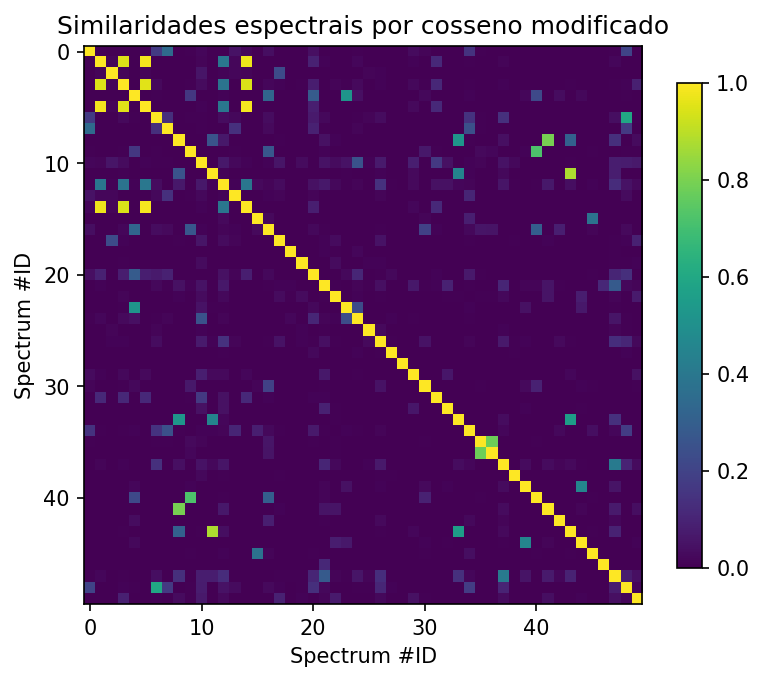

In [64]:
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array[:50, :50]['CosineGreedy_score'], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Similaridades espectrais por cosseno modificado")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")

In [66]:
(scores_array[:50, :50]['CosineGreedy_matches'] >= min_match)

array([[ True, False, False, ...,  True,  True, False],
       [False,  True, False, ...,  True, False, False],
       [False, False,  True, ..., False,  True, False],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [67]:
scores_array[:50, :50]["CosineGreedy_score"]

array([[1.00000000e+00, 6.41050958e-03, 1.70386100e-04, ...,
        6.67728149e-03, 2.00981399e-01, 2.03351451e-03],
       [6.41050958e-03, 1.00000000e+00, 1.37105333e-02, ...,
        1.93096626e-02, 3.51204936e-04, 9.58054743e-05],
       [1.70386100e-04, 1.37105333e-02, 1.00000000e+00, ...,
        1.77990108e-03, 2.30706624e-03, 1.08205802e-03],
       ...,
       [6.67728149e-03, 1.93096626e-02, 1.77990108e-03, ...,
        1.00000000e+00, 7.67400588e-02, 4.25970108e-02],
       [2.00981399e-01, 3.51204936e-04, 2.30706624e-03, ...,
        7.67400588e-02, 1.00000000e+00, 1.65097414e-02],
       [2.03351451e-03, 9.58054743e-05, 1.08205802e-03, ...,
        4.25970108e-02, 1.65097414e-02, 1.00000000e+00]])

In [68]:
scores_array[:50, :50]["CosineGreedy_score"] \
           * (scores_array[:50, :50]["CosineGreedy_matches"] >= min_match)

array([[1.        , 0.        , 0.        , ..., 0.00667728, 0.2009814 ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.01930966, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.00230707,
        0.        ],
       ...,
       [0.00667728, 0.01930966, 0.        , ..., 1.        , 0.07674006,
        0.04259701],
       [0.2009814 , 0.        , 0.00230707, ..., 0.07674006, 1.        ,
        0.01650974],
       [0.        , 0.        , 0.        , ..., 0.04259701, 0.01650974,
        1.        ]])

Text(0, 0.5, 'Spectrum #ID')

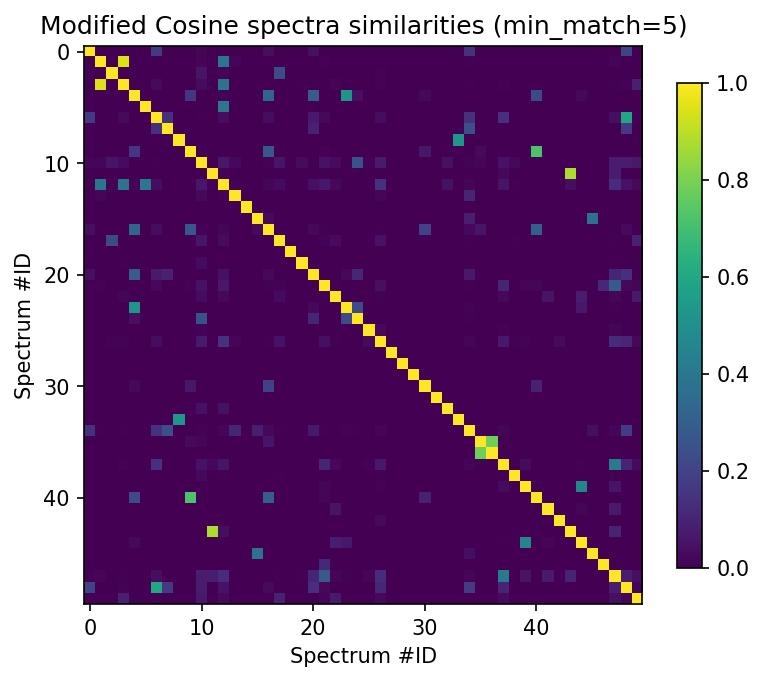

In [69]:
min_match = 5

plt.figure(figsize=(6,6), dpi=150)

plt.imshow(scores_array[:50, :50]["CosineGreedy_score"] \
           * (scores_array[:50, :50]["CosineGreedy_matches"] >= min_match), cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Modified Cosine spectra similarities (min_match=5)")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")

In [70]:
scores_array[0, 0]['CosineGreedy_matches']

40

Existe, por exemplo, um ponto brilhante bem fora da diagonal para `spectra[11]`, então vamos dar uma olhada nele!

In [73]:
min_match = 5

sorted_matches = scores.scores_by_query(spectra[11], 'CosineGreedy_score', sort=True)
best_matches = [x for x in sorted_matches if x[1][1] >= min_match][:10]
[x[1] for x in best_matches]

[(1., 151),
 (0.89042014, 11),
 (0.87730721, 9),
 (0.84035065, 11),
 (0.77416918, 8),
 (0.74923209, 7),
 (0.72854032, 8),
 (0.65486209, 9),
 (0.55896333, 7),
 (0.52316093, 8)]